In [66]:
#Importing libraries

%matplotlib notebook
import pandas as pd
from numpy import array
import numpy as np
import math
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


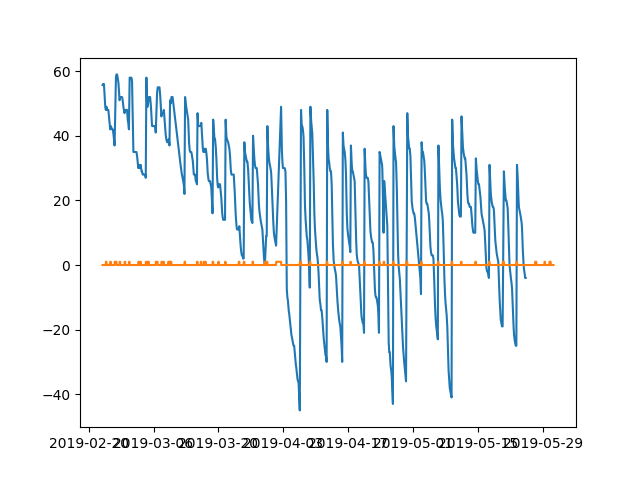

In [67]:
# Read Training data

train = pd.read_csv('Train.csv', index_col=0, parse_dates=True)

#Plot Training data
plt.plot(train.index, train[['Soil humidity 2','Irrigation field 2']])
plt.show()


In [68]:

# Extract pressures
pressure_list = train['Pressure (KPa)'].tolist()

#Extract temperatures
temp_list = train['Air temperature (C)'].tolist()

#Filter "NaN"
pressure_list_without_nan = []
for i in range(len(pressure_list)):
    if (np.isnan(pressure_list[i])):
        pressure_list_without_nan.append(pressure_list_without_nan[i - 24*12])
    else:
        pressure_list_without_nan.append(pressure_list[i])

#Filter "NaN"
temp_list_without_nan = []
for i in range(len(temp_list)):
    if (np.isnan(temp_list[i])):
        temp_list_without_nan.append(temp_list_without_nan[i - 24*12])
    else:
        temp_list_without_nan.append(temp_list[i])
        



In [69]:
def firstNanIndex(listfloats, k):
    for i, item in enumerate(listfloats):
        if i > k and math.isnan(item) == True:
            return i
        
def firstNonNan(listfloats, j):
    bol = False
    for i, item in enumerate(listfloats[j:]):
        if math.isnan(item) == False:
            bol = True
            return i+j, item
    if (bol == False):
        return len(listfloats) -1 , listfloats[len(listfloats)-1]
    
def cleanSerie(columnName):
    field = train[columnName].tolist()
    cleanedList = [x for x in field if (math.isnan(x) == False)]
    return cleanedList

                


In [70]:

# Remove "NaN" from serie
field2_without_Nan = cleanSerie('Soil humidity 2')
field2_without_Nan = field2_without_Nan[:-3]
field2 = train['Soil humidity 2'].tolist()
index2 = firstNanIndex(field2, 0)
field2 = field2[:index2+ 1747]


In [71]:
def prepare_data(train,field_number, field_without_Nan, preds_horizon):
    target = train[['Pressure (KPa)','Air temperature (C)', 'Soil humidity ' + str(field_number),'Irrigation field ' +str(field_number)]][:len(field_without_Nan)]
    target['last'] = target[['Soil humidity ' + str(field_number)]].shift(1)
   
    target['diff'] = target['Soil humidity ' + str(field_number)] - target['last']
   
    target['pressure'] = target['Pressure (KPa)']   
    target['pressure_last'] = target[['pressure']].shift(1)
    target['diff_pressure'] = target['pressure'] - target['pressure_last']    
   
    target['temperature'] = target['Air temperature (C)']
    target['temperature_last'] = target[['temperature']].shift(1)
    target['diff_temperature'] = target['temperature'] - target['temperature_last']
    
   
    
    
    del target['Air temperature (C)']
    del target['temperature_last']
    del target['pressure_last']   
    del target['temperature']
    del target['pressure']   
    del target['Pressure (KPa)']
   

  
    target['irrigation_now'] = train['Irrigation field ' +str(field_number)][:len(field_without_Nan)]
    X = target.dropna()
   
    
    del X['Soil humidity ' + str(field_number)]
    del X['last']
    
   
  
    Y = X['diff']
    
    del X['Irrigation field ' +str(field_number)]   
    del X['diff']

    return X, Y


In [72]:
def train_xgboost(data_X, data_Y, random_state=0):
    my_imputer = SimpleImputer()
    final_train = my_imputer.fit_transform(data_X)
    train_X, test_X, train_y, test_y = train_test_split(final_train, data_Y, test_size=0.1, random_state=random_state)
    my_model = XGBRegressor(n_estimators=1500, learning_rate=0.1, random_state=random_state)
    my_model.fit(train_X, train_y, early_stopping_rounds=5,eval_metric=["rmse"], eval_set=[(test_X, test_y)], verbose=False)
    return my_model


In [73]:
def findStep(last_prediction, moisture_list, index):
    j = index
    while(np.isnan(moisture_list[j])):
        j =j+1
    step = (moisture_list[j] - last_prediction ) /(j-index)
    return step
    


In [74]:
def get_Predictions(model, field_number, field_without_Nan, field, train_last_index, preds_horizon):
    moisture = field[len(field_without_Nan)-1:]
    irrigationFrame = train[['Irrigation field ' +str(field_number)]][len(field_without_Nan)-1:len(field_without_Nan)+preds_horizon]
    

    preds = []
    k=0
    index=-1
    bol = False
    for i in range(preds_horizon):
        index= index + 1

        temperature = temp_list_without_nan[train_last_index + index]
        temperature_last = temp_list_without_nan[train_last_index + index - 1]
        temperature_diff = temperature - temperature_last
        
        pressure = pressure_list_without_nan[train_last_index + index]
        pressure_last = pressure_list_without_nan[train_last_index + index - 1]
        pressure_diff = pressure - pressure_last
        
        irrigation = irrigationFrame.iloc[i+1]['Irrigation field ' + str(field_number)]
        if(np.isnan(irrigation)):
            irrigation =0

        if(irrigation == 0):
            bol = False
            x= np.array([pressure_diff, temperature_diff, irrigation])
            x = x[np.newaxis,...]
            prediction = model.predict(x) 
        if(irrigation == 1 and index ==0):
            x= np.array([pressure_diff, temperature_diff, irrigation])
            x = x[np.newaxis,...]
            prediction = model.predict(x) 
        if(irrigation == 1 and index > 0):
            if(bol == False):
                step =findStep(preds[-1], moisture, index)
                prediction = [step]
                bol = True
            else:
                prediction = [step]                
     
        if np.isnan(moisture[i]):
            preds.append(prediction[0]+ preds[-1])
            k=k+1
        else:
            preds.append(prediction[0]+ moisture[i])
            k=0
            
        k=k+1
    return preds

In [78]:
seed = 90973

# Prepare the data
data_X, data_Y = prepare_data(train,2, field2_without_Nan, 1747)

#Train our podel
model2 = train_xgboost(data_X, data_Y, seed)

#Extract the predictions from the model
preds2 = get_Predictions(model2, 2, field2_without_Nan,field2, 26301, 1747)
print(preds2)



[-4.0699688196182251, -4.1371210217475891, -4.1929595470428467, -4.2487980723381042, -4.3046365976333618, -4.3703923225402832, -4.4361480474472046, -4.4919865727424622, -4.5591387748718262, -4.5950899720191956, -4.6344555020332336, -4.7016077041625977, -4.7687599062919617, -4.8236843347549438, -4.8721343278884888, -4.9279728531837463, -4.9838113784790039, -5.0396499037742615, -5.095488429069519, -5.1640353798866272, -5.2189598083496094, -5.2674098014831543, -5.3158597946166992, -5.3830119967460632, -5.4735980629920959, -5.5352771878242493, -5.5969563126564026, -5.6320960521697998, -5.667235791683197, -5.7230743169784546, -5.7902265191078186, -5.8460650444030762, -5.9019035696983337, -5.9519690275192261, -6.0156569480895996, -6.0714954733848572, -6.1386476755142212, -6.1944862008094788, -6.2503247261047363, -6.2987747192382812, -6.3472247123718262, -6.4378107786178589, -6.5283968448638916, -6.5884284973144531, -6.6484601497650146, -6.7156123518943787, -6.8061984181404114, -6.85368919372

TypeError: list indices must be integers, not list

In [76]:
total =[]
total.extend(preds2)


1747


In [82]:
submission =pd.read_csv('SampleSubmission.csv')
submission['Values']= total
submission.to_csv('submission.csv', index=False)

